# Марков Михаил, 5030102/10201

In [79]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import warnings
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
warnings.filterwarnings("ignore")

# Загрузка датасета

In [80]:
df = pd.read_csv('data.csv')
df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [81]:
# Определение размера датасета
print(df.shape)

# сделаем столбец id индексом 
df = df.set_index('id', drop = True)

(188533, 13)


# Определим пропущенные значения и заменим их

Text(0.5, 1.0, 'Процент пропущенных данных по признакам')

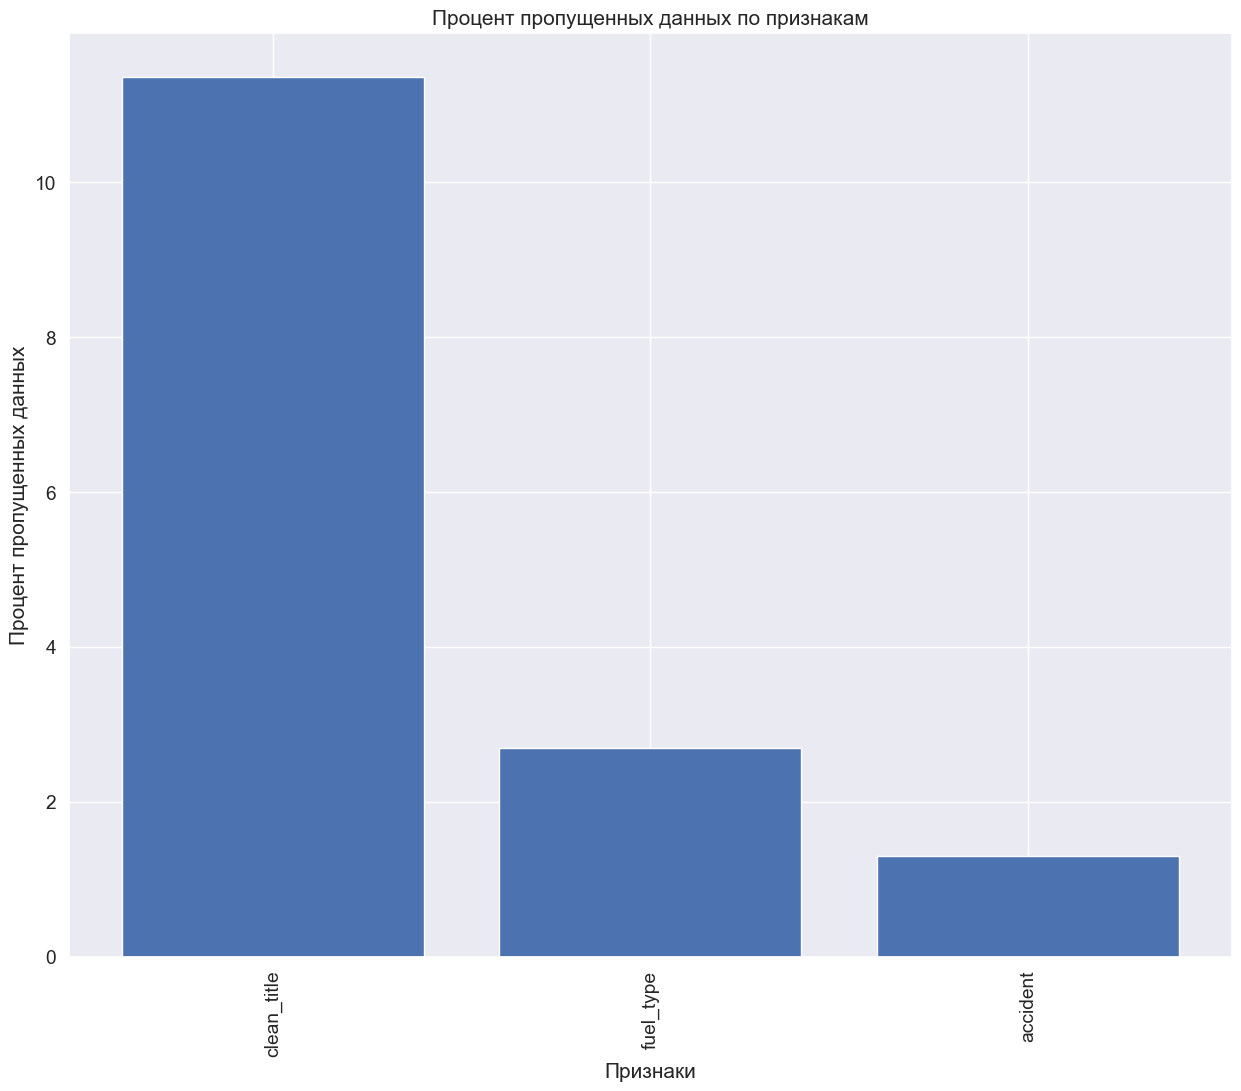

In [82]:
# Рассчитываем процент пропущенных значений для каждого столбца
missing_data_percentage = (df.isnull().mean() * 100)

# Сортируем столбцы с пропущенными значениями
top_missing_data = missing_data_percentage[missing_data_percentage > 0].sort_values(ascending=False)

# Строим график
fig, ax = plt.subplots(figsize=(15, 12))
ax.bar(top_missing_data.index, top_missing_data.values)

# Устанавливаем тики и метки для оси X
ax.set_xticks(range(len(top_missing_data)))  # Позиции тиков
ax.set_xticklabels(top_missing_data.index, rotation=90)  # Метки для этих позиций

ax.set_xlabel('Признаки', fontsize=15)
ax.set_ylabel('Процент пропущенных данных', fontsize=15)
ax.set_title('Процент пропущенных данных по признакам', fontsize=15)


# Пропущенных значений немного, но они существуют.
### Проанализируем их, заменим их и перекодируем их в зависимости от типа признака

In [83]:
# Для столбца "clean_title"
print(df["clean_title"].value_counts(dropna=False))

# Для столбца "fuel_type"
print(df["fuel_type"].value_counts(dropna=False))

# Для столбца "accident"
print(df["accident"].value_counts(dropna=False))

clean_title
Yes    167114
NaN     21419
Name: count, dtype: int64
fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64
accident
None reported                             144514
At least 1 accident or damage reported     41567
NaN                                         2452
Name: count, dtype: int64


In [84]:
# Заполняем пропуски в 'clean_title' значением 'No' и преобразуем 'Yes' в 1, остальное в 0
df['clean_title'].fillna('No', inplace=True)
df['clean_title'] = df['clean_title'].apply(lambda x: 1 if x == 'Yes' else 0)

In [85]:
# Заменяем '–' и 'not supported' на 'Unknown' в 'fuel_type' и заполняем пропуски
df['fuel_type'] = df['fuel_type'].replace(['–', 'not supported'], 'Unknown')

# Определяем машины бех указанного типа топлива
nan_fuel_type = df[df['fuel_type'].isna()]
print(nan_fuel_type)
print(nan_fuel_type['engine'].str.contains('Electric').value_counts())
# Больше машин, у которых не определен тип топлива, являются электрическими
df['fuel_type'].fillna('Electric', inplace=True)
df['fuel_type'].replace('', 'Electric', inplace=True)

df['fuel_type'].replace({'Plug-In Hybrid': 'Hybrid'}, inplace=True)

        brand                    model  model_year  milage fuel_type  \
id                                                                     
11      Tesla            Model S P100D        2015   81500       NaN   
32      Tesla            Model S P100D        2018   30300       NaN   
51      Tesla       Model 3 Long Range        2020   38360       NaN   
52      Tesla              Model X 75D        2021   88000       NaN   
161     Tesla       Model S Long Range        2021    9500       NaN   
...       ...                      ...         ...     ...       ...   
188368   Ford   Mustang Mach-E Premium        2022    2058       NaN   
188455   Ford        Mustang Mach-E GT        2022    8000       NaN   
188462   Ford        Mustang Mach-E GT        2023    9000       NaN   
188484   Ford            Model X P100D        2018   52000       NaN   
188489  Tesla  Model X Long Range Plus        2022    4786       NaN   

                                             engine   transmiss

In [86]:
# Заполняем пропуски в 'accident' значением 'None reported' и преобразуем данные в 1 или 0
df['accident'].fillna('None reported', inplace=True)
df['accident'] = df['accident'].apply(lambda x: 1 if x == 'At least 1 accident or damage reported' else 0)

In [87]:
df.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
price           0
dtype: int64

# Теперь все знаечния являются определенными

# Обзор признаков, поиск связей

In [88]:
df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

## Наиболее интересные признаки с первого взгляда это brand, model_year, milage, accident. 
## Проверим предположение, построив матрицу корреляции

In [89]:
# Преобразуем год создания в возраст
df['age'] = pd.Timestamp('now').year - df['model_year']
df.drop(columns='model_year', axis=1, inplace=True)
df.head()

,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,age
id,,,,,,,,,,,,
0,MINI,Cooper S Base,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,0,1,4200,17
1,Lincoln,LS V8,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,1,1,4999,22
2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,0,1,13900,22
3,Genesis,G90 5.0 Ultimate,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,0,1,45000,7
4,Mercedes-Benz,Metris Base,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,0,1,97500,3


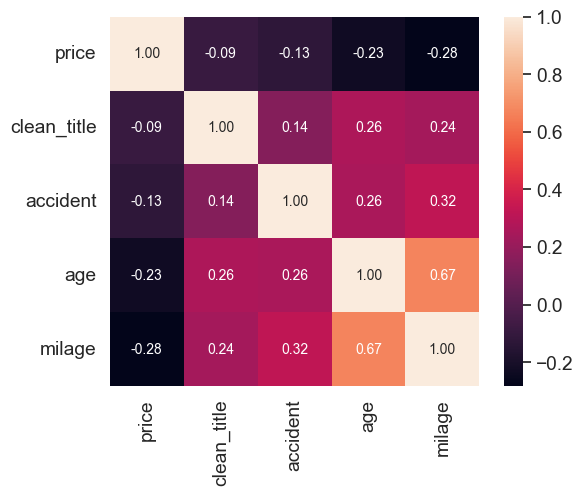

In [90]:
numeric_df = df.select_dtypes(include=[np.number])

# Вычисляем матрицу корреляции на числовых данных
corr_matrix = numeric_df.corr()

cols = corr_matrix.nlargest(5, 'price')['price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Выводы по первичному анализу:
- пробег и правда плохо влияет на цену
- возраст автомобиля и его пробег сильно коррелируют (чем старее машина, тем скорее всего больше пробег)
## Продолжим анализ

Index(['milage', 'accident', 'clean_title', 'price', 'age'], dtype='object')


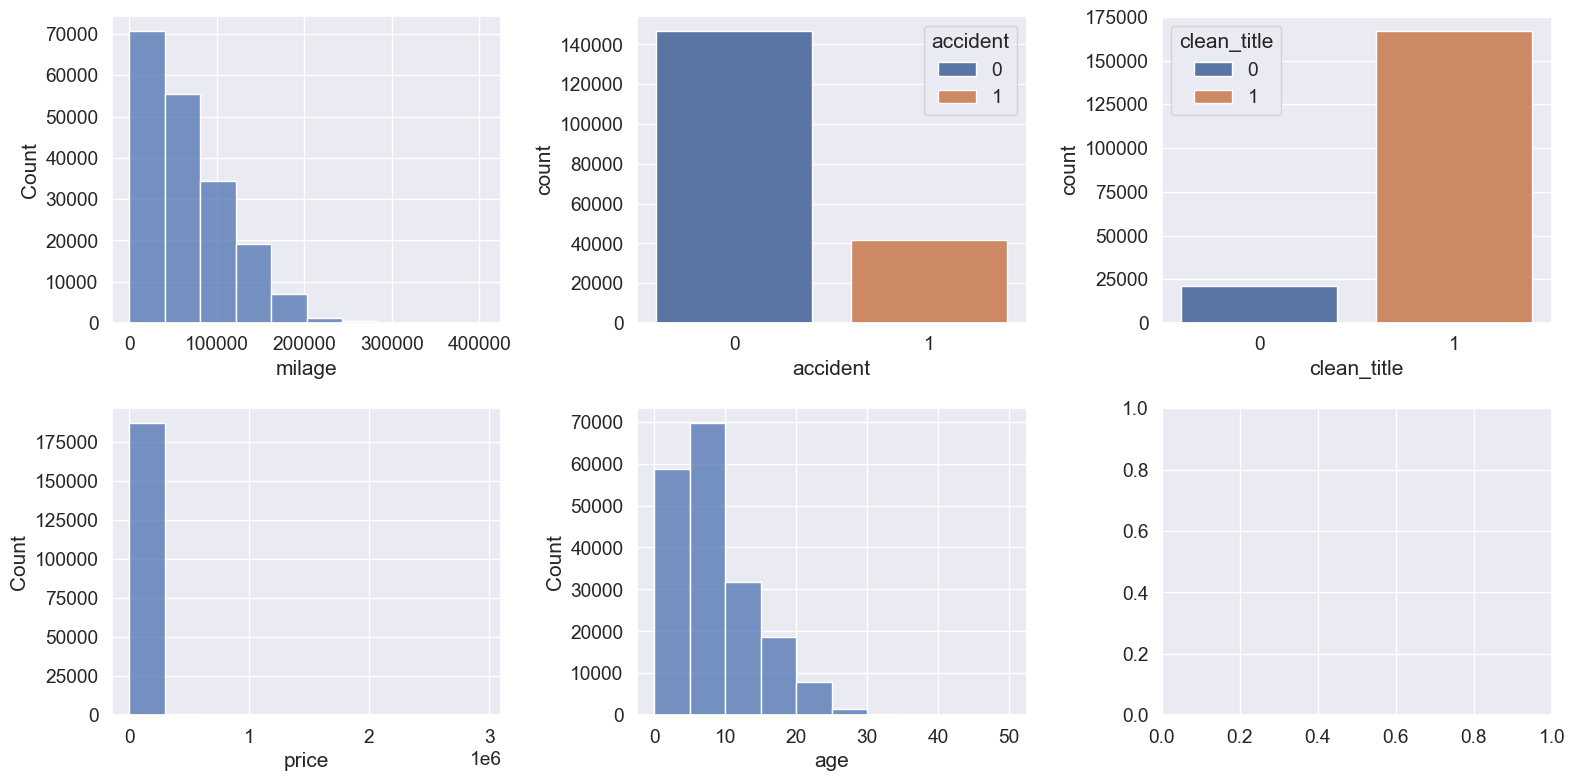

In [91]:
numeric_cols = df.select_dtypes(include='number').columns
print(numeric_cols)

plt.subplots(2, 3, figsize=(16, 8))

for i, col in enumerate(numeric_cols, 1):

    plt.subplot(2, 3, i)
    if col not in ['accident', 'clean_title']:
        sns.histplot(data=df, x=col, bins=10)
    else:
        sns.countplot(data=df, x=col, 
                      hue=col, dodge=False)

plt.tight_layout()
plt.show()

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col'],
      dtype='object')


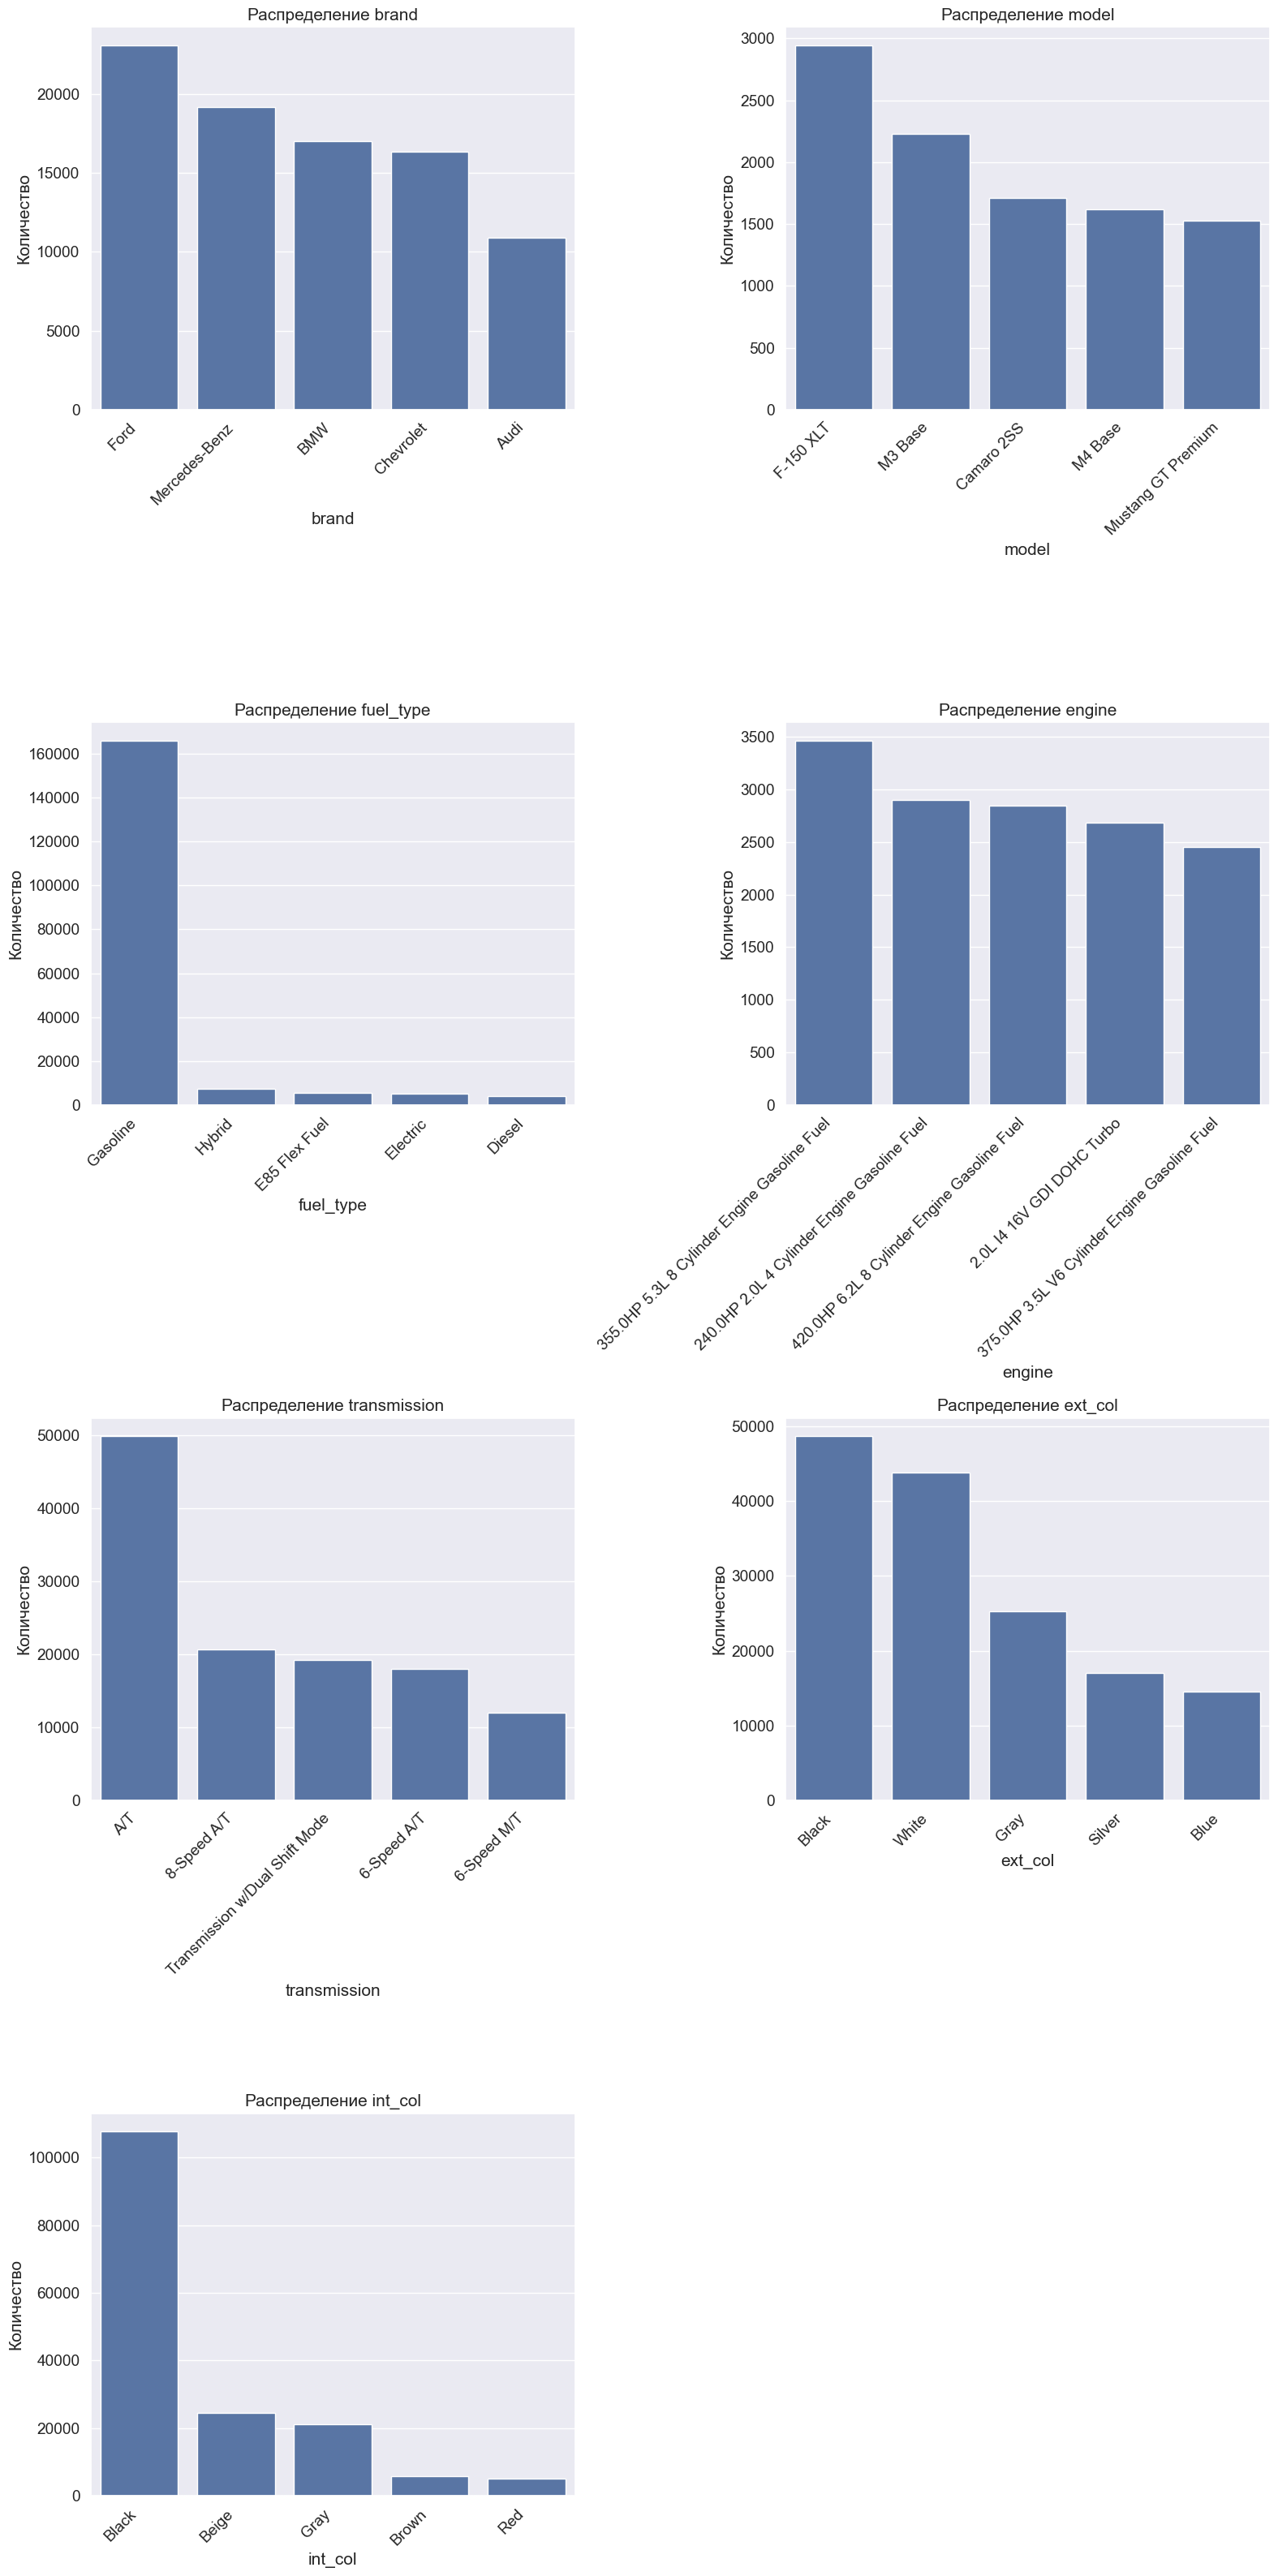

In [ ]:
categoric_cols = df.select_dtypes(include='object').columns
print(categoric_cols)

# Создаем фигуру и массив осей
fig, axes = plt.subplots(4, 2, figsize=(16, 32))
axes = axes.flatten()  # Преобразуем массив осей в одномерный для удобства

for i, col in enumerate(categoric_cols):
    ax = axes[i]
    sns.countplot(data=df, x=col, dodge=False,
                  order=df[col].value_counts()[:5].index, ax=ax)
    ax.set_title(f'Распределение {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Количество')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Проанализируем бренд автомобиля подробнее.

## Построим бокс-плот Тьюки для соотношения цены машины и ее бренда.

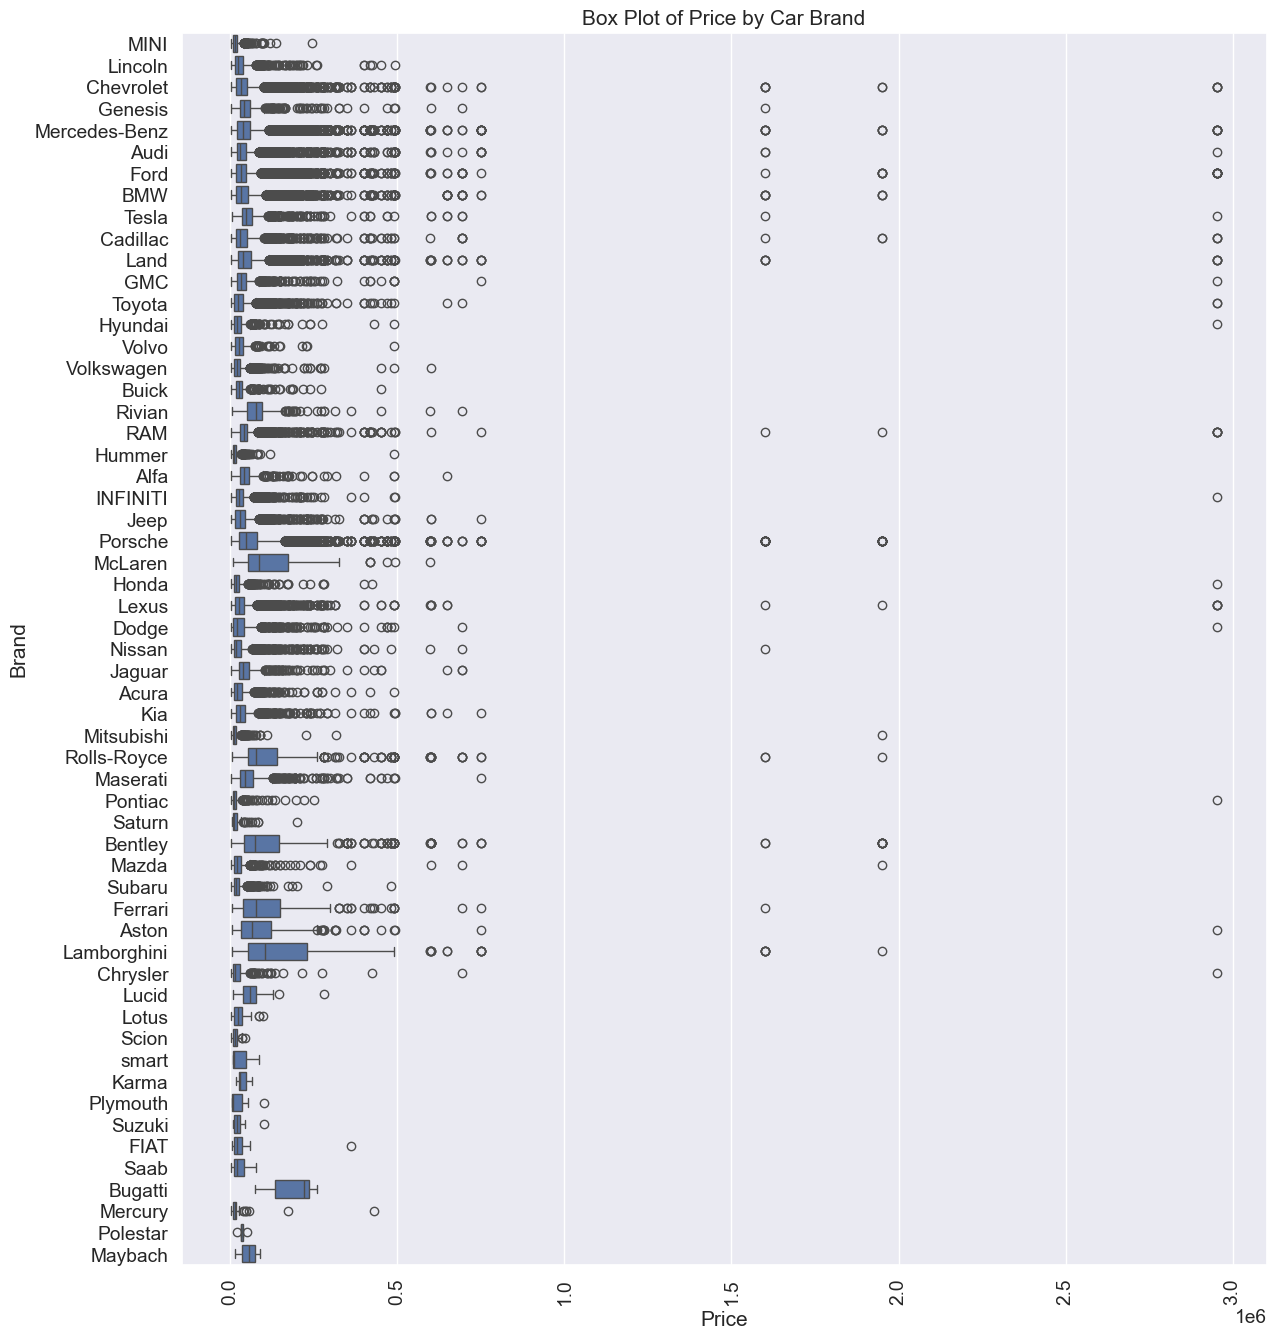

In [93]:
plt.figure(figsize=(14, 16))
sns.boxplot(y='brand', x='price', data=df[:180000])
plt.title('Box Plot of Price by Car Brand')
plt.ylabel('Brand')
plt.xlabel('Price')
plt.xticks(rotation=90)
plt.show()

# Явно выделим машины премиум класса, добавив соответствующее поле.

In [94]:
royal_brands = ['Bugatti', 'Lamborghini', 'Rolls-Royce', 'Bentley', 'McLaren', 
                'Ferrari',  'Porsche', 'Lexus', 'Maserati', 
                'Maybach',  'Land', 'Alfa',  'Mercedes-Benz', 'BMW', 'Chevrolet', 'Audi']


df['premium'] = df.apply(lambda row: 1 if row['brand'] in royal_brands and row['model'] else 0, axis=1)

# Закодируем категориальные признаки и повторно рассмотрим матрицу корреляции.

In [95]:
le = LabelEncoder()
for x in df.select_dtypes(include='object').columns:
    df[x] = le.fit_transform(df[x])

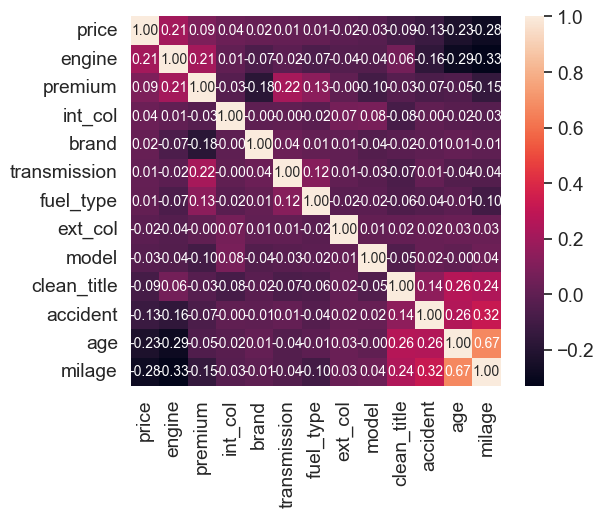

In [96]:
# Вычисляем матрицу корреляции на числовых данных
corr_matrix = df.corr()

cols = corr_matrix.nlargest(25, 'price')['price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Как и ожидалось, возраст коррелирует с пробегом.

# Обзор целевой переменной

In [97]:
# Обзор целевой переменной
df['price'].describe()

count    1.885330e+05
mean     4.387802e+04
std      7.881952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64

### Описание целевой переменной `price`

- **count**: 188,533 — количество наблюдений (строк) в столбце `price`.
- **mean**: 43,878.02 — средняя цена автомобиля в выборке составляет примерно 43,878 долларов.
- **std**: 78,819.52 — стандартное отклонение, показывающее разброс цен от среднего значения. Это относительно высокое значение, что указывает на большое разнообразие цен в наборе данных.
- **min**: 2,000.00 — минимальная цена в данных составляет 2,000 долларов.
- **25%**: 17,000.00 — 25% автомобилей имеют цену ниже 17,000 долларов.
- **50% (медиана)**: 30,825.00 — медианная цена автомобиля составляет 30,825 долларов, то есть половина автомобилей стоит меньше этой суммы.
- **75%**: 49,900.00 — 75% автомобилей стоят менее 49,900 долларов.
- **max**: 2,954,083.00 — максимальная цена в наборе данных достигает 2,954,083 долларов, что значительно выше остальных значений.

### Выводы:
- Разброс цен велик: максимальное значение почти в 3 миллиона долларов явно выделяется на фоне остальных цен.
- Большинство автомобилей находятся в ценовом диапазоне от 2,000 до 50,000 долларов.
- Стандартное отклонение свидетельствует о большом разбросе данных, что может указывать на наличие как дешевых, так и очень дорогих автомобилей в выборке.


Ассиметрия: 20.268453
Эксцесс: 623.965342


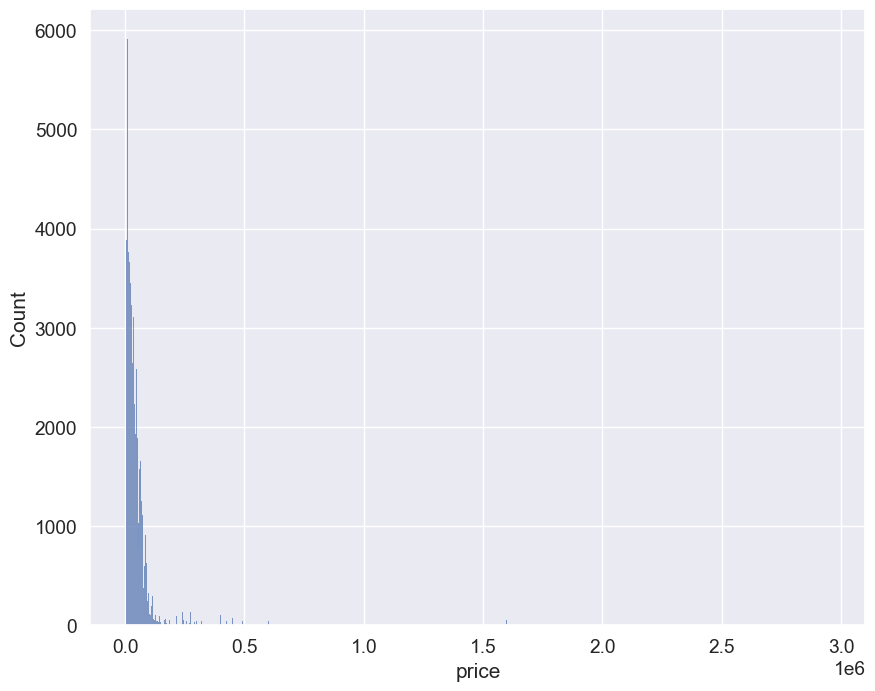

In [98]:
# визуализация
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(df['price'])

# Рассчитываем асимметрию и эксцесс
print("Ассиметрия: %f" % df['price'].skew())
print("Эксцесс: %f" % df['price'].kurt())

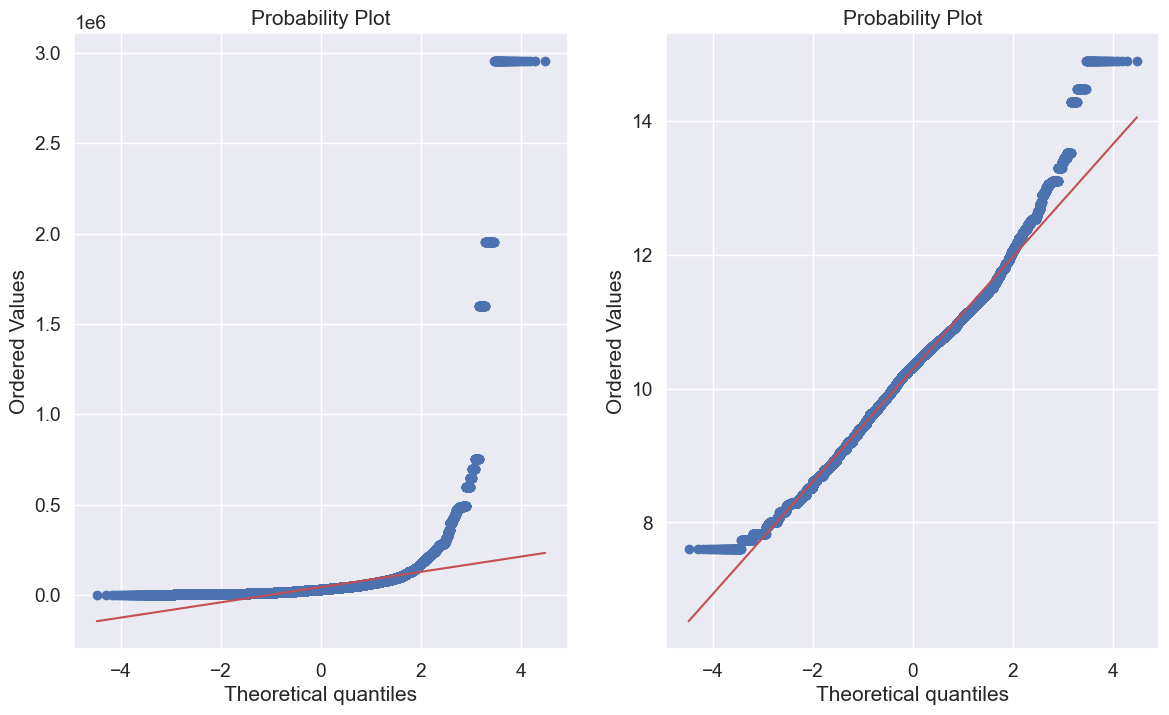

In [99]:
fig = plt.figure(figsize = (14,8))

# Распределение на необработанных данных
fig.add_subplot(1,2,1)
res = stats.probplot(df['price'], plot=plt)

# Распределение при условии, что мы прологарифмировали 'SalePrice'
fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df['price']), plot=plt)

## Логарифмирование исправило ситуацию

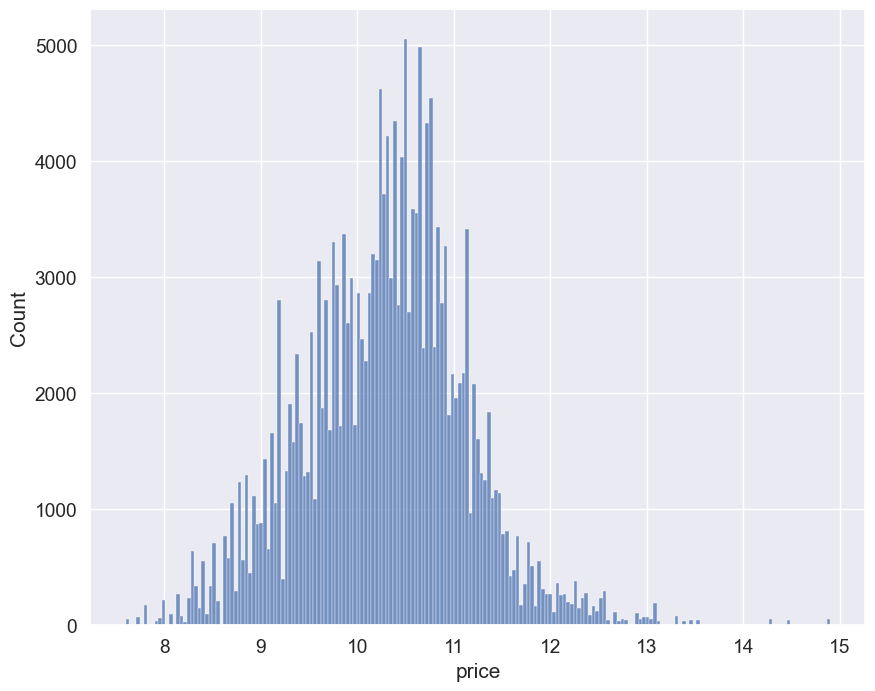

In [100]:
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(np.log1p(df['price']))
df = df.drop(df[(df['price'] > 50000)].index)

## Разделим выборку на тестовую и обучающую

In [101]:
# Разделяем данные на обучающую и тестовую выборки
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
# Выводим первые несколько строк обучающей выборки для предварительного просмотра
df_train.head()

,brand,model,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,age,premium
id,,,,,,,,,,,,,
58741,4,986,64800,3,1015,31,38,31,0,1,36950,8,1
69680,3,1284,16000,3,1067,49,29,31,0,1,39900,4,1
183861,4,97,96273,3,325,31,304,14,0,1,16750,10,1
11230,22,1771,76313,3,198,32,133,14,0,1,29182,3,0
155779,39,260,91545,3,152,38,304,14,0,1,16000,10,0


## Теоретическая информация о модели Lasso

**Lasso (Least Absolute Shrinkage and Selection Operator)** — это линейный метод регрессии, который сочетает обычную линейную регрессию с регуляризацией $ L_1 $-нормы. Он предназначен для повышения устойчивости модели, предотвращения переобучения и автоматического отбора признаков.  

### Ключевые особенности Lasso:

1. **Формула**:
      Модель Lasso минимизирует следующую функцию потерь:
   $$
   \min_{\beta} \frac{1}{2n} \sum_{i=1}^n (y_i - \mathbf{x}_i^\top \beta)^2 + \alpha \sum_{j=1}^p |\beta_j|,
   $$
   где:
   - $ y_i $ — истинные значения целевой переменной;
   - $ \mathbf{x}_i $ — вектор входных признаков;
   - $ \beta $— вектор коэффициентов модели;
   - $ \alpha $ — коэффициент регуляризации ($ \alpha \geq 0 $).

   Второе слагаемое ( $ L_1 $ -норма) добавляет штраф за ненулевые значения коэффициентов $ \beta $, тем самым способствуя их обнулению.

2. **Регуляризация**:
   - При $ \alpha = 0 $ Lasso сводится к обычной линейной регрессии без регуляризации.
   - При увеличении $ \alpha $ модель становится проще (уменьшается количество ненулевых коэффициентов), что способствует борьбе с переобучением.

3. **Отбор признаков**:
   Lasso автоматически исключает наименее важные признаки, присваивая их коэффициентам нулевые значения. Это делает модель интерпретируемой и упрощает работу с высокоразмерными данными.

4. **Применение**:
   Lasso используется, когда:
   - Нужно выделить наиболее важные признаки;
   - Данные содержат много нерелевантных или коррелированных признаков;
   - Необходимо уменьшить сложность модели.

6. **Гиперпараметр $ \alpha $**:
   - Управляет компромиссом между сложностью модели и точностью предсказания.
   - Оптимальное значение $ \alpha $ часто подбирается с использованием перекрёстной проверки.

## Введем метрику для оценки точности

In [102]:
def regression_accuracy(y_true, y_pred, tolerance=0.25):
    return  np.mean(np.abs(y_true - y_pred) <= tolerance * y_true)

In [103]:
# Применяем логарифмирование ко всей выборке
df_train['price'] = np.log1p(df_train['price'])

X_train = df_train.drop(columns=['price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['price'])
y_test = df_test['price']

# Обучаем модель Lasso
lasso = Lasso(alpha=0.1)  # Параметр alpha контролирует регуляризацию
lasso.fit(X_train, y_train)

# Предсказания
y_pred = lasso.predict(X_test)
y_pred= np.expm1(y_pred)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Результаты
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print("R^2 Score:", r2)

# Применим эту метрику к нашим данным
accuracy = regression_accuracy(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

MAE: 6341.07
MSE: 70560589.46
RMSE: 8400.04
R^2 Score: 0.5749880094546007
Accuracy: 55.65%
